# 통신사 고객 이탈 예측 모델 만들기

---
## 요약

### 데이터 정보
- 출처: 캐클,  https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets
- 데이터명: telecom_churn_data.csv
- 데이터 설명: 통신사 고객 정보
- 컬럼 설명:
    - State : 주(행정구역)
    - Account length : 계정 길이
    - Area code : 지역 코드
    - International plan : 국제 계획
    - Voice mail plan: 음성 메세지 계획
    - Number vmail messages: 음성 메세지 사용 횟수
    - Total day minutes: 총 하루 통화 분
    - Total day calls: 총 하루 통화 횟수
    - Total day charge: 총 하루 통화 요금
    - Total eve minutes: 총 저녁 통화 분
    - Total eve calls: 총 저녁 통화 횟수
    - Total eve charge: 총 저녁 통화 요금
    - Total night minutes: 총 밤 통화 분
    - Total night calls: 총 밤 통화 횟수
    - Total night charge: 총 밤 통화 요금
    - Total intl minutes: 총 국제 통화 분
    - Total intl calls: 총 국제 통화 횟수
    - Total intl charge: 총 국제 통화 요금
    - Customer service calls: 고객 서비스 전화
    - Churn: 고객 이탈 여부 (0: 미이탈, 1: 이탈)

### 결과
- Logistic Regression : (0.42857142857142855, 0.0759493670886076, 0.12903225806451613)
- LGBM : (0.9661016949152542, 0.7215189873417721, 0.8260869565217391)

In [81]:
model_box

,logistic,lightgbm,lightgbm_opt
accuracy,0.848315,0.955056,0.953184
precision,0.428571,0.966102,0.965517
recall,0.075949,0.721519,0.708861
f1 score,0.129032,0.826087,0.817518


## 해석
- 고객 이탈 예측의 오류에는 두 가지가 있다
    1. '이탈할 사람을 이탈하지 않을 것이라고 잘못 예측' -> 1종 오류
    2. '이탈하지 않을 사람을 이탈할 것이라고 잘못 예측' -> 2종 오류
- 회사의 측면에서 봤을 때 두번째 오류보다 첫 번째 오류에 대한 수정이 더 중요하다고 생각할 것이다.
- 두 번째 경우에는 예산을 불필요하게 더 사용했을 뿐이지만, 첫 번째의 경우에는 고객이 이탈해버리게 되는 것이기 때문이다.
- 첫 번째 오류는 낮은 재현율에 따른 손해이고, 두 번째 오류는 낮은 정밀도에 따른 손해인 점을 고려하여 <b>'재현율을 높이는 것에 더 집중한다.'</b>
- Gird Search로 lightgbm 모델을 최적화한 결과, 재현율 및 다른 성능들이 기존 모델보다 더 낮게 나오므로 기존의 모델을 유지한다.
- 따라서, Recall 값이 가장 높은 <b>기존의 LGBM 모델</b>을 선택한다.
---

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
churn = pd.read_csv('telecom_churn_data.csv', index_col = 0).reset_index()

In [3]:
churn.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
churn.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [5]:
len(churn)

2666

In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

## 컬럼별 결측치 확인

In [7]:
null_cnt_df = pd.DataFrame(churn.isnull().sum()).rename(columns = {0:'null_count'}).reset_index()
null_cnt_df['null_ratio'] = round(null_cnt_df['null_count']/len(churn) * 100, 2)
null_cnt_df

,index,null_count,null_ratio
0,State,0,0.0
1,Account length,0,0.0
2,Area code,0,0.0
3,International plan,0,0.0
4,Voice mail plan,0,0.0
5,Number vmail messages,0,0.0
6,Total day minutes,0,0.0
7,Total day calls,0,0.0
8,Total day charge,0,0.0
9,Total eve minutes,0,0.0


## 컬럼 별 값 확인 (범주형)

In [9]:
churn[['State','Account length','Area code','International plan','Voice mail plan','Churn']]

,State,Account length,Area code,International plan,Voice mail plan,Churn
0,KS,128,415,No,Yes,False
1,OH,107,415,No,Yes,False
2,NJ,137,415,No,No,False
3,OH,84,408,Yes,No,False
4,OK,75,415,Yes,No,False
...,...,...,...,...,...,...
2661,SC,79,415,No,No,False
2662,AZ,192,415,No,Yes,False
2663,WV,68,415,No,No,False
2664,RI,28,510,No,No,False


In [10]:
churn.nunique()

# state, Account length, Area code 변수는 고유값으로 보이므로 쓰지 않음.

State                       51
Account length             205
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       42
Total day minutes         1489
Total day calls            115
Total day charge          1489
Total eve minutes         1442
Total eve calls            120
Total eve charge          1301
Total night minutes       1444
Total night calls          118
Total night charge         885
Total intl minutes         158
Total intl calls            21
Total intl charge          158
Customer service calls      10
Churn                        2
dtype: int64

In [13]:
churn.drop(columns = ['State','Account length','Area code'], inplace=True)

## 컬럼 별 값 확인 (수치형)

In [14]:
churn.columns

Index(['International plan', 'Voice mail plan', 'Number vmail messages',
       'Total day minutes', 'Total day calls', 'Total day charge',
       'Total eve minutes', 'Total eve calls', 'Total eve charge',
       'Total night minutes', 'Total night calls', 'Total night charge',
       'Total intl minutes', 'Total intl calls', 'Total intl charge',
       'Customer service calls', 'Churn'],
      dtype='object')

In [15]:
churn[[ 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
      'Number vmail messages']]

,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Number vmail messages
0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,25
1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,26
2,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,0
2662,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,36
2663,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
2664,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0


## Eda

In [16]:
churn.describe()

,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [17]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


# 그래프 타이틀 한글 출력
matplotlib.rcParams['font.family'] ='Malgun Gothic'

# 그래프 사이즈 지정
plt.rcParams['figure.figsize'] = [14, 10]

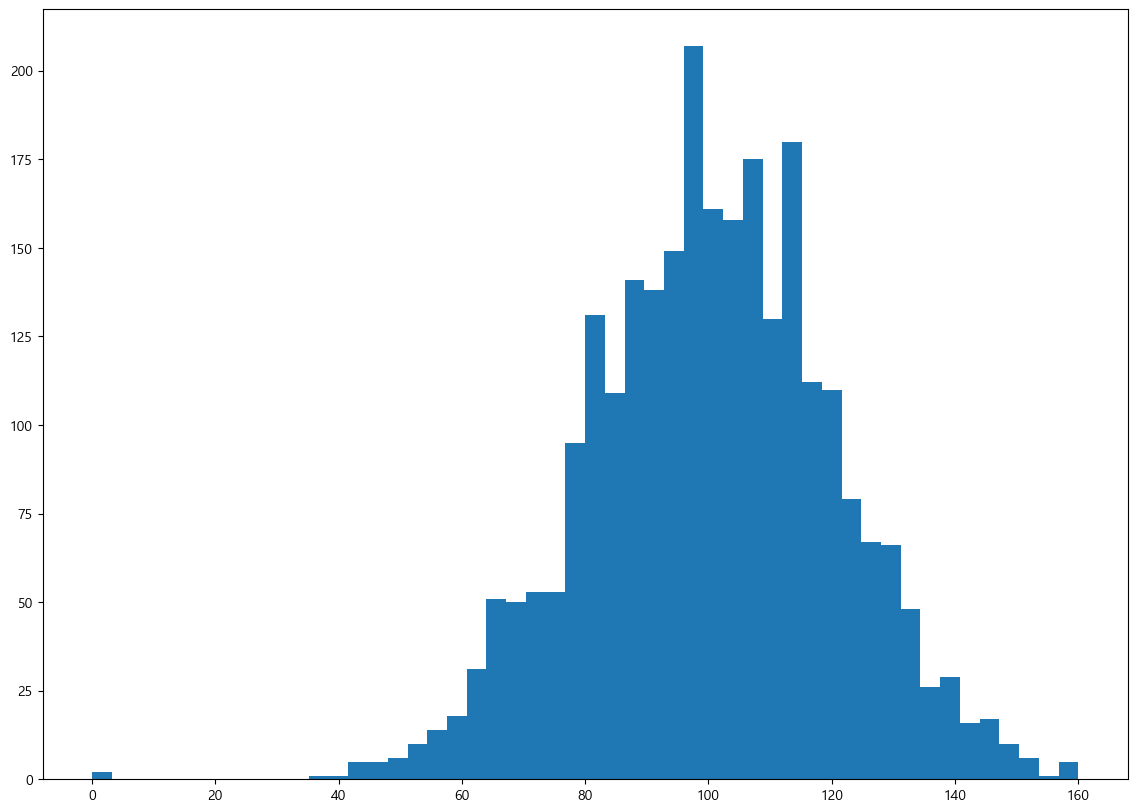

In [18]:
# 하루 전화 횟수 :
plt.hist(churn['Total day calls'], bins=50)
plt.show()

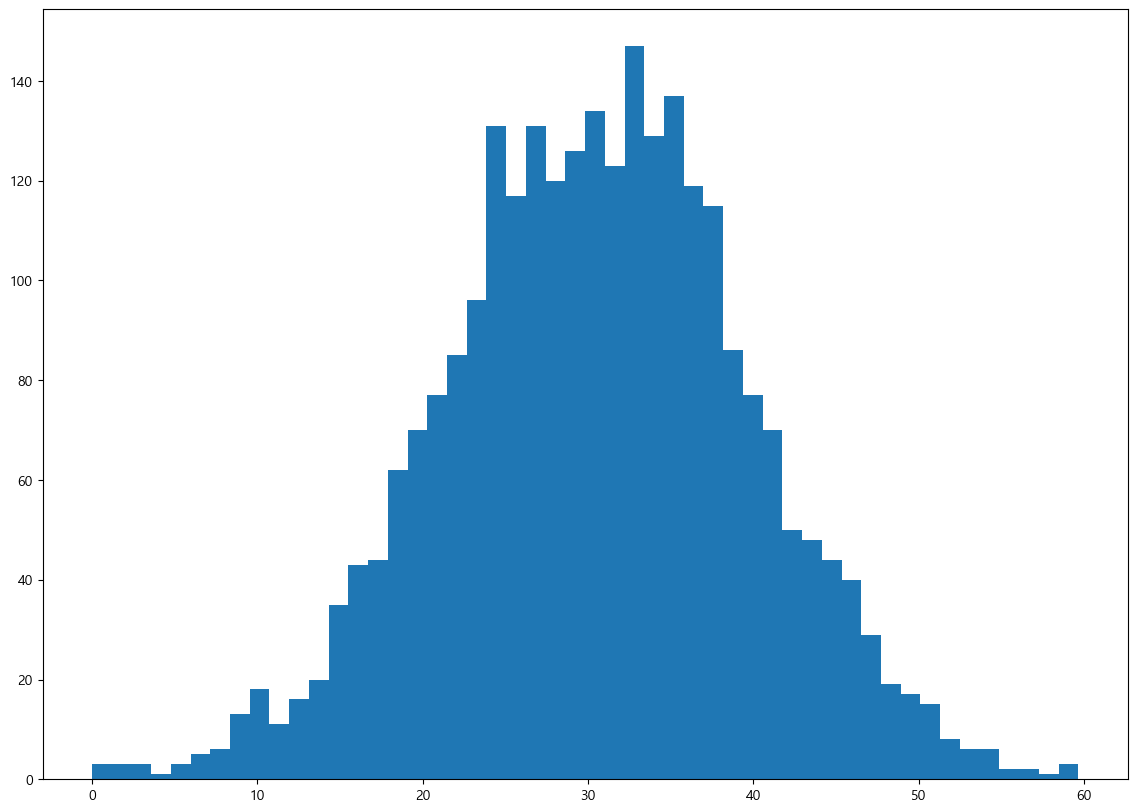

In [19]:
# 총 하루 요금 :
plt.hist(churn['Total day charge'], bins=50)
plt.show()

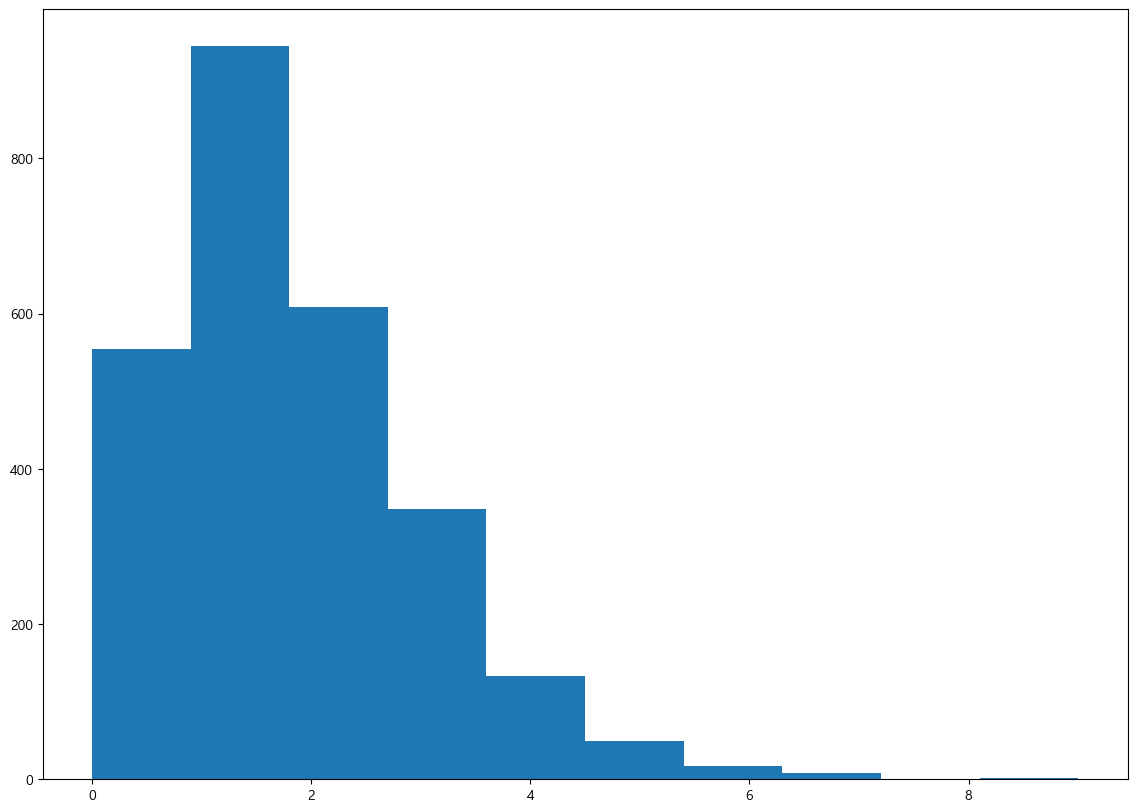

In [20]:
# 고객 서비스 전화 횟수 :
plt.hist(churn['Customer service calls'], bins=10)
plt.show()

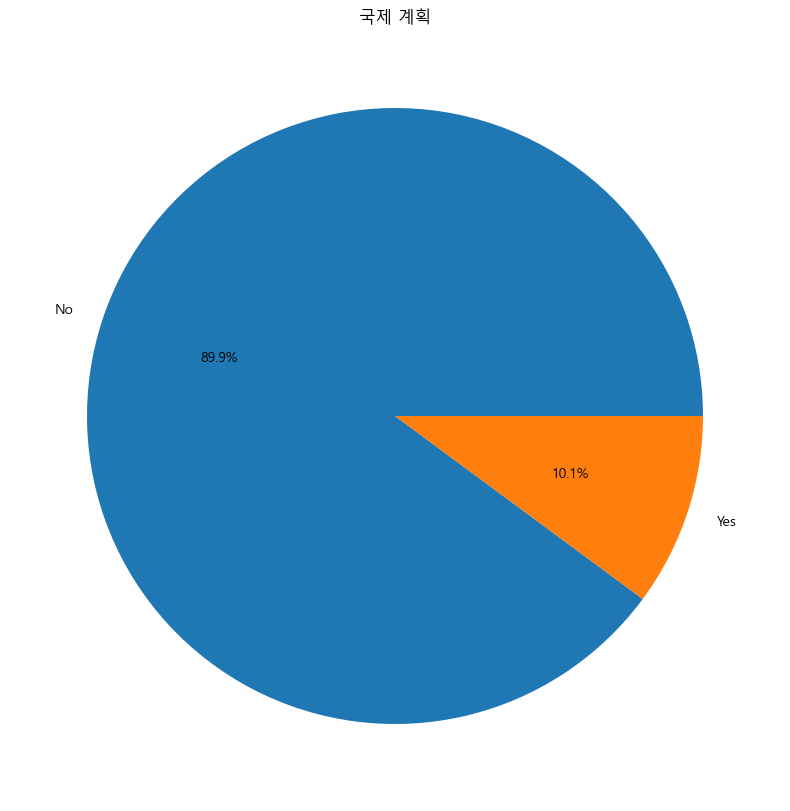

In [21]:
grade = churn['International plan'].value_counts()

plt.pie(grade, labels = grade.index, autopct = '%2.1f%%')
plt.title('국제 계획')
plt.show()

## 변수 선택

C:\Users\leah5\AppData\Local\Temp\ipykernel_15940\225409476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(churn.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')


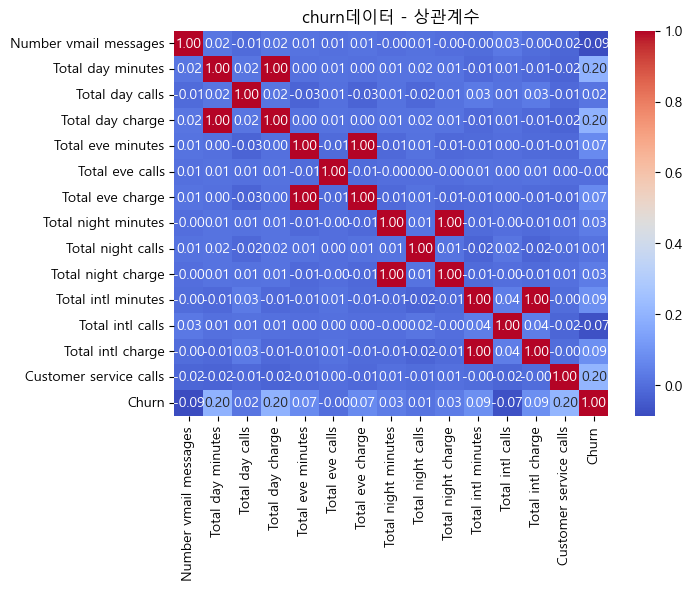

In [22]:
plt.figure(figsize = (7, 5))
sns.heatmap(churn.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('churn데이터 - 상관계수')
plt.show()

<Axes: xlabel='Total day charge', ylabel='Total day minutes'>

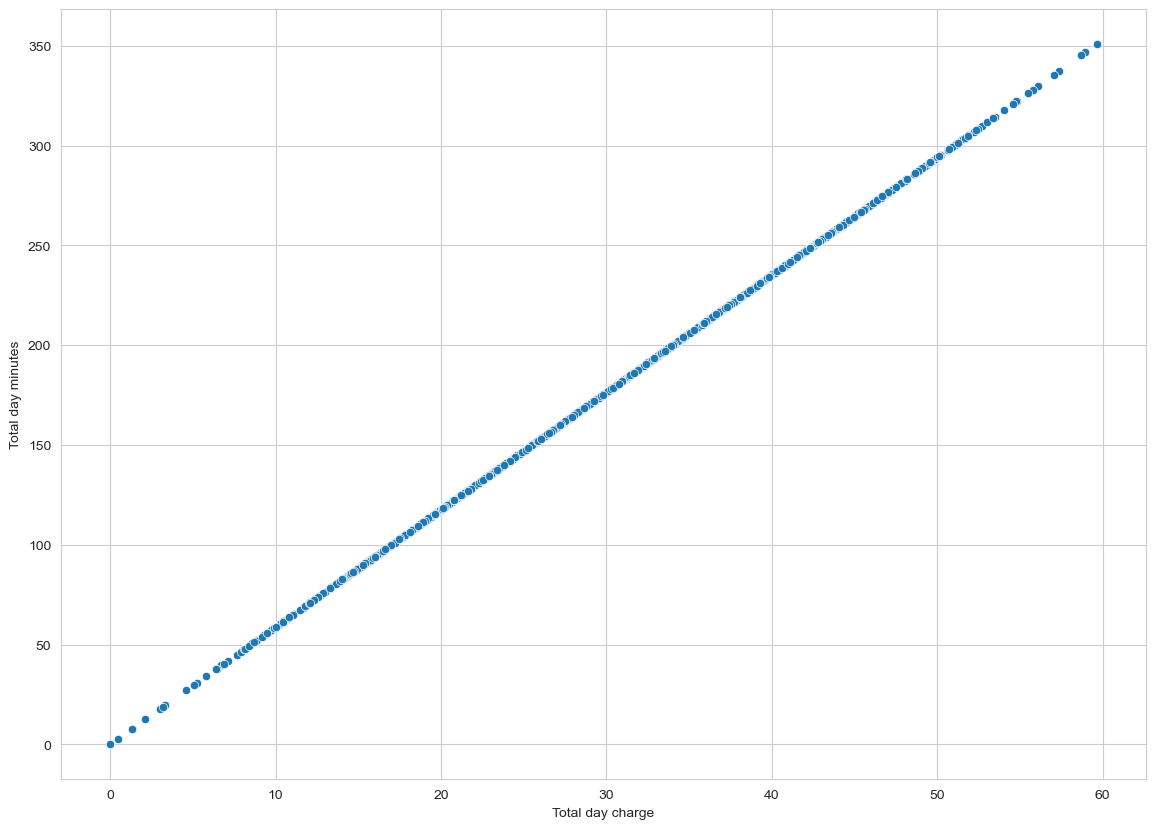

In [23]:
# 변수 간 연관성 검토
sns.set_style('whitegrid')
sns.scatterplot(data=churn, x='Total day charge', y='Total day minutes')

<Axes: xlabel='Total eve charge', ylabel='Total eve minutes'>

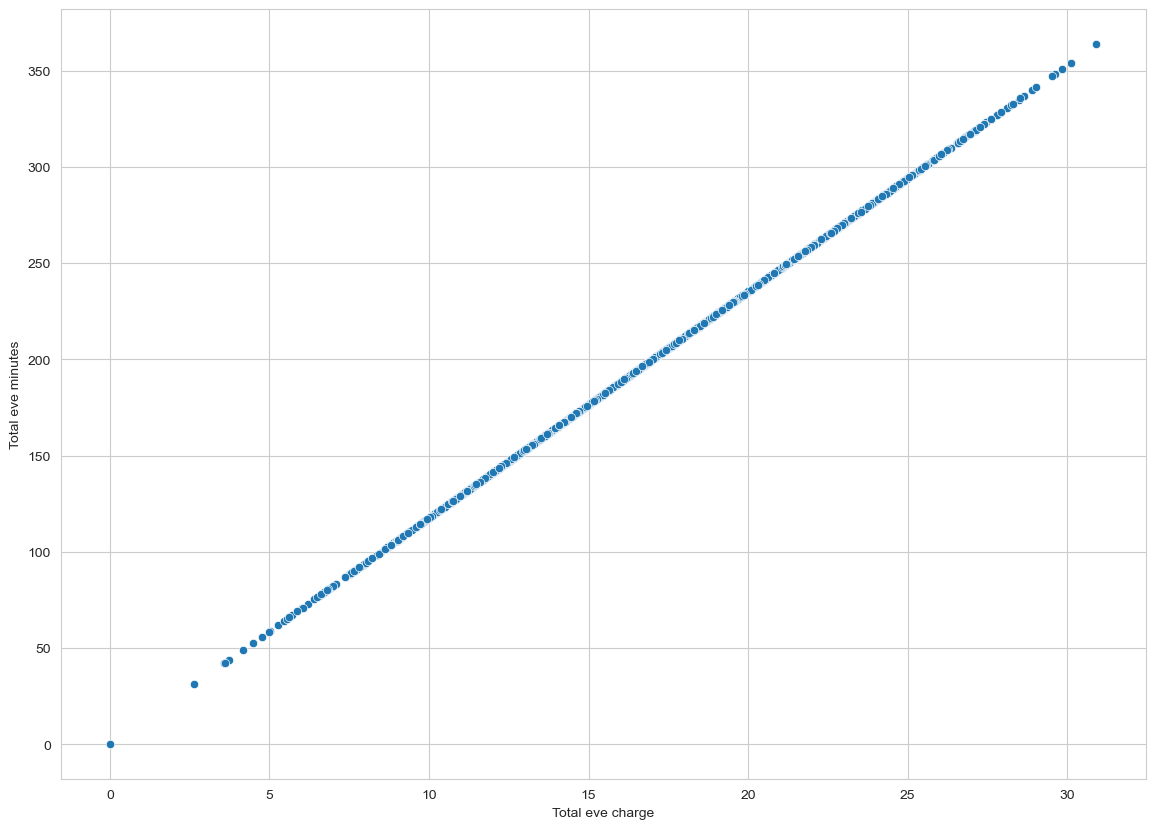

In [24]:
sns.set_style('whitegrid')
sns.scatterplot(data=churn, x='Total eve charge', y='Total eve minutes')

# charge 변수와 minutes 변수는 강한 상관관계를 띄우고 있고 선형적인 비례 관계를 가지고 있다.
# 이는 모델의 과적합을 불러일으킬 수 있으므로 두 변수 중 charge 변수를 제거한다.

In [25]:
# 필요 칼럼만 가져오기
churn.drop(columns = ['Total day charge','Total eve charge','Total night charge','Total intl charge'], inplace=True)

## 라벨 인코딩

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report

import copy
import random

In [28]:
churn_re = copy.deepcopy(churn)

encoder = LabelEncoder()

churn_re['International plan'] = encoder.fit_transform(churn_re['International plan'])
churn_re['Voice mail plan'] = encoder.fit_transform(churn_re['Voice mail plan'])
churn_re['Churn'] = encoder.fit_transform(churn_re['Churn'])

In [29]:
churn_re

,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,134.7,98,189.7,68,221.4,128,11.8,5,2,0
2662,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
2663,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
2664,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0


In [33]:
churn_re['Churn'].value_counts()

0    2278
1     388
Name: Churn, dtype: int64

In [34]:
churn['Churn'].value_counts()

False    2278
True      388
Name: Churn, dtype: int64

## 데이터셋 나누기

In [31]:
# 학습 데이터, 레이블 분리
X = churn_re.drop(columns={'Churn'})
y = churn_re['Churn']

In [35]:
# Train, Test 데이터 분리 (이탈 미이탈 값 확인)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("[Train] 전체 : {}, 이탈: {}, 미이탈: {}".format(len(X_train), y_train[y_train == 1].shape[0], y_train[y_train == 0].shape[0]))
print("[Test] 전체 : {}, 이탈: {}, 미이탈: {}".format(len(X_test), y_test[y_test == 1].shape[0], y_test[y_test == 0].shape[0]))

[Train] 전체 : 2132, 이탈: 309, 미이탈: 1823
[Test] 전체 : 534, 이탈: 79, 미이탈: 455


## 모델 학습

#### 1. Logistic regression 모델

In [65]:
from sklearn.linear_model import LogisticRegression

# Logistic 모델 학습
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train, y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [66]:
# 예측 및 결과
y_pred = log_model.predict(X_test)
y_pred = list(y_pred)
print("[Predict] 이탈: {}, 미이탈 {}".format(y_pred.count(1), y_pred.count(0)))

[Predict] 이탈: 14, 미이탈 520


In [67]:
# [Test] 이탈: 79, 미이탈: 455
# [Predict] 이탈: 14, 미이탈 520

In [68]:
# Accuracy 측정
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.848314606741573

In [69]:
# precision, recall, f1 score 측정
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.42857142857142855, 0.0759493670886076, 0.12903225806451613, None)

In [70]:
from sklearn.metrics import confusion_matrix
# cmtx 구성
# [[ TP, FN
#    FP, TN]]
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[1,0]),
    index = ['실제: 이탈(1)', '실제: 미이탈(0)'],
    columns = ['예측: 이탈(1)', '예측: 미이탈(0)']
)

cmtx

,예측: 이탈(1),예측: 미이탈(0)
실제: 이탈(1),6,73
실제: 미이탈(0),8,447


##### 2. LGBM 모델

In [56]:
# LGBM 모델 학습
! pip install lightgbm
from lightgbm import LGBMClassifier

Defaulting to user installation because normal site-packages is not writeable


In [57]:
lgbm_model = LGBMClassifier(random_state=0, verbose=-1) # 같은 데이터 넣었을때 동일한 값이 나오도록하는 것
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=0, verbose=-1)

In [58]:
# 예측 결과
y_pred = lgbm_model.predict(X_test)
y_pred = list(y_pred)
print("[Predict] 이탈: {}, 미이탈 {}".format(y_pred.count(1), y_pred.count(0)))
# y_test: 결과 값(실제 값)

[Predict] 이탈: 59, 미이탈 475


In [59]:
# [Test] 이탈: 79, 미이탈: 455
# [Predict] 이탈: 59, 미이탈 475

In [60]:
# Accuracy 측정
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9550561797752809

In [61]:
# precision, recall, f1 score 측정
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.9661016949152542, 0.7215189873417721, 0.8260869565217391, None)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

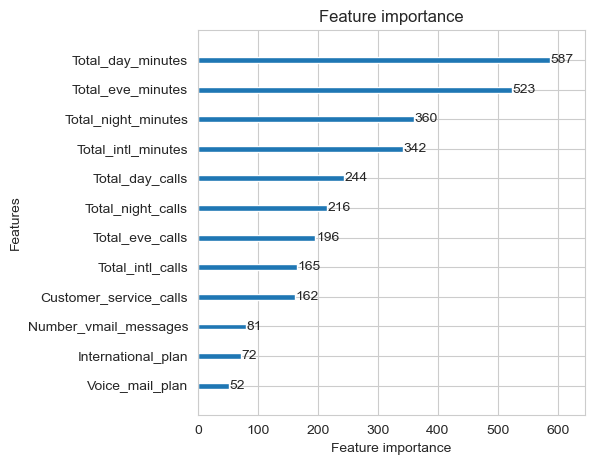

In [62]:
# 영향도 (주요 변수 시각화)
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5))
plot_importance(lgbm_model, ax=ax)

In [64]:
from sklearn.metrics import confusion_matrix
# cmtx 구성
# [[ TP, FN
#    FP, TN]]
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[1,0]),
    index = ['실제: 이탈(1)', '실제: 미이탈(0)'],
    columns = ['예측: 이탈(1)', '예측: 미이탈(0)']
)

cmtx

,예측: 이탈(1),예측: 미이탈(0)
실제: 이탈(1),57,22
실제: 미이탈(0),2,453


## 결과
- Logistic Regression : (0.42857142857142855, 0.0759493670886076, 0.12903225806451613)
- LGBM : (0.9661016949152542, 0.7215189873417721, 0.8260869565217391)

In [71]:
model_box = pd.DataFrame(columns=['logistic','lightgbm'],
                         index = ['accuracy','precision','recall','f1 score'])

In [76]:
model_box['logistic']=[0.848314606741573 ,0.42857142857142855, 0.0759493670886076, 0.12903225806451613]
model_box['lightgbm']=[0.9550561797752809 ,0.9661016949152542, 0.7215189873417721, 0.8260869565217391]

In [77]:
model_box

,logistic,lightgbm
accuracy,0.848315,0.955056
precision,0.428571,0.966102
recall,0.075949,0.721519
f1 score,0.129032,0.826087


## 해석
- 고객 이탈 예측의 오류에는 두 가지가 있다
    1. '이탈할 사람을 이탈하지 않을 것이라고 잘못 예측' -> 1종 오류
    2. '이탈하지 않을 사람을 이탈할 것이라고 잘못 예측' -> 2종 오류
- 회사의 측면에서 봤을 때 두번째 오류보다 첫 번째 오류에 대한 수정이 더 중요하다고 생각할 것이다.
- 두 번째 경우에는 예산을 불필요하게 더 사용했을 뿐이지만, 첫 번째의 경우에는 고객이 이탈해버리게 되는 것이기 때문이다.
- 첫 번째 오류는 낮은 재현율에 따른 손해이고, 두 번째 오류는 낮은 정밀도에 따른 손해인 점을 고려하여 <b>'재현율을 높이는 것에 더 집중한다.'</b>
- 따라서, Recall 값이 더 높은 LGBM 모델을 선택한다.

## 최적화

In [78]:
### GridSearch로 최적화 하기
from sklearn.model_selection import GridSearchCV

# LightGBM 모델 생성
model = LGBMClassifier(verbose=-1)

# 하이퍼파라미터 범주 설정
param_grid = {'max_depth': [3, 5, 7],
              'num_leaves': [10, 20, 30], # 넓이
              'min_child_samples': [10, 20, 30], # 데이터를 얼마나 학습할지, 최소의 양
              'learning_rate': [0.01, 0.05, 0.1]} # 학습률

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid= param_grid)

# 그리드 최적화
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터
grid_search.best_params_

# 최적의 하이퍼파라미터로 학습된 모델 가져오기
best_model = grid_search.best_estimator_

# 예측 수행
y_pred = best_model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.9655172413793104, 0.7088607594936709, 0.8175182481751826, None)

In [79]:
accuracy_score(y_test, y_pred)

0.9531835205992509

- Gird Search로 최적화한 결과, 재현율 및 다른 성능들이 기존 모델보다 더 낮게 나오므로 기존의 모델을 유지한다.

In [80]:
model_box['lightgbm_opt']=[0.9531835205992509 ,0.9655172413793104, 0.7088607594936709, 0.8175182481751826]
model_box

,logistic,lightgbm,lightgbm_opt
accuracy,0.848315,0.955056,0.953184
precision,0.428571,0.966102,0.965517
recall,0.075949,0.721519,0.708861
f1 score,0.129032,0.826087,0.817518
